## Reproducible code for a dot graph of tissue blocks per organ per consortium in CFDE

## Install and import libraries

In [105]:
%pip install requests pandas seaborn matplotlib numpy

import os
import csv
from pprint import pprint
import json
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Define functions

In [106]:
def download_if_not_exists(url, folder):
    os.makedirs(folder, exist_ok=True)

    filename = os.path.basename(url.rstrip("/"))
    if not filename.lower().endswith(".csv"):
        filename += ".csv"

    filepath = os.path.join(folder, filename)

    # If file already exists
    if os.path.exists(filepath):
        print(f"File already exists: {filepath}")
        return filepath

    # Download file
    response = requests.get(url)
    response.raise_for_status()

    with open(filepath, "wb") as f:
        f.write(response.content)

    print(f"Downloaded file: {filepath}")
    return filepath

## Load data from HRA API

In [107]:
# tissue_blocks_json = download_if_not_exists("https://apps.humanatlas.io/api/v1/ds-graph", "data")
tissue_blocks_csv = download_if_not_exists("https://apps.humanatlas.io/api/grlc/hra/datasets-list-organs-providers.csv", "downloads")
tissue_blocks_csv

File already exists: downloads\datasets-list-organs-providers.csv


'downloads\\datasets-list-organs-providers.csv'

## Preprocess data into correct format:
`organ, provider_name, count`


In [108]:
df = pd.read_csv("downloads/datasets-list-organs-providers.csv")
df

,dataset,organ_iri,organ,consortium,tissue_provider
0,https://gtexportal.org/home/tissue/Artery_Coro...,http://purl.obolibrary.org/obo/UBERON_0004537,blood vasculature,GTEx,GTEx
1,https://gtexportal.org/home/tissue/Artery_Coro...,http://purl.obolibrary.org/obo/UBERON_0004537,blood vasculature,GTEx,GTEx
2,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.obolibrary.org/obo/UBERON_0000955,brain,Allen Institute for Brain Science,Allen Institute
3,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.obolibrary.org/obo/UBERON_0000955,brain,Allen Institute for Brain Science,Allen Institute
4,https://api.cellxgene.cziscience.com/dp/v1/col...,http://purl.obolibrary.org/obo/UBERON_0000955,brain,Allen Institute for Brain Science,Allen Institute
...,...,...,...,...,...
8221,https://entity.api.hubmapconsortium.org/entiti...,http://purl.obolibrary.org/obo/UBERON_0000995,uterus,HuBMAP,TMC - University of Pennsylvania
8222,https://entity.api.hubmapconsortium.org/entiti...,http://purl.obolibrary.org/obo/UBERON_0000995,uterus,HuBMAP,TMC - University of Pennsylvania
8223,https://entity.api.hubmapconsortium.org/entiti...,http://purl.obolibrary.org/obo/UBERON_0000995,uterus,HuBMAP,TMC - University of Pennsylvania
8224,https://gtexportal.org/home/tissue/Artery_Coro...,http://purl.obolibrary.org/obo/UBERON_0004537,vascular system,GTEx,GTEx


In [109]:
# Count unique datasets by organ and consortium
df_count = (
    df.groupby(["organ", "consortium"])["dataset"]
    .nunique()
    .reset_index(name="unique_dataset_count")
)
df_count

,organ,consortium,unique_dataset_count
0,blood vasculature,GTEx,2
1,brain,Allen Institute for Brain Science,10
2,brain,SenNet,300
3,heart,GTEx,10
4,heart,HCA,129
...,...,...,...
79,urinary bladder,HCA,6
80,urinary bladder,HuBMAP,28
81,uterus,GTEx,1
82,uterus,HuBMAP,184


In [110]:
# Clean organ labels
df_count["organ"] = df_count["organ"].apply(
    lambda organ: "skin" if "of body" in organ else organ
)

df_count.loc[df_count["organ"] == "male reproductive system", "organ"] = "prostate"
df_count

,organ,consortium,unique_dataset_count
0,blood vasculature,GTEx,2
1,brain,Allen Institute for Brain Science,10
2,brain,SenNet,300
3,heart,GTEx,10
4,heart,HCA,129
...,...,...,...
79,urinary bladder,HCA,6
80,urinary bladder,HuBMAP,28
81,uterus,GTEx,1
82,uterus,HuBMAP,184


In [111]:
# Make organs upper case
df_count["organ"] = df_count["organ"].str.capitalize()
df_count

,organ,consortium,unique_dataset_count
0,Blood vasculature,GTEx,2
1,Brain,Allen Institute for Brain Science,10
2,Brain,SenNet,300
3,Heart,GTEx,10
4,Heart,HCA,129
...,...,...,...
79,Urinary bladder,HCA,6
80,Urinary bladder,HuBMAP,28
81,Uterus,GTEx,1
82,Uterus,HuBMAP,184


In [112]:
# Filter
cfde_efforts = ["HuBMAP", "SenNet", "GTEx", "SPARC", "HTAN"]

df_count.loc[~df_count["consortium"].isin(cfde_efforts), "consortium"] = "Other"

df_visualize = df_count.sort_values("organ")
df_visualize

,organ,consortium,unique_dataset_count
0,Blood vasculature,GTEx,2
1,Brain,Other,10
2,Brain,SenNet,300
3,Heart,GTEx,10
4,Heart,Other,129
...,...,...,...
79,Urinary bladder,Other,6
80,Urinary bladder,HuBMAP,28
82,Uterus,HuBMAP,184
81,Uterus,GTEx,1


## Visualize

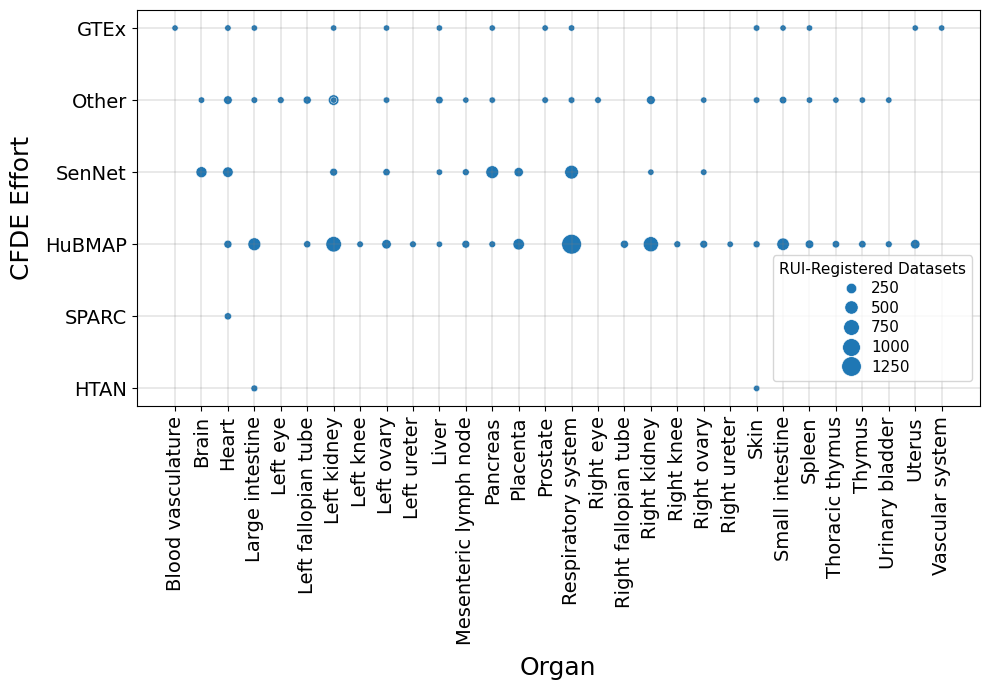

In [113]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/digital-objects-per-organ.vl.json

# Create the line plot
g = sns.scatterplot(
    data=df_visualize,
    x="organ",
    y="consortium",
    size="unique_dataset_count",
    sizes=(20, 200),
)


# Set white background for figure and axes
g.figure.set_facecolor("white")
g.set_facecolor("white")

# Set thin grey grid lines
g.grid(
    True, which="major", axis="both", linestyle="-", linewidth=0.25, color="grey"
)
# g.grid(
#     True, which="minor", axis="both", linestyle=":", linewidth=0.25, color="lightgrey"
# )

# increase figure size to accommodate facet grid
g.figure.set_size_inches(10, 7)


# Customize the plot
plt.xlabel("Organ", labelpad=8, fontsize=18)
plt.ylabel("CFDE Effort", labelpad=8, fontsize=18)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Adjust tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# adjust legend
legend = g.legend(
    title="RUI-Registered Datasets",
    loc="upper right",
    labelspacing=0.3,
    fontsize=11,
    title_fontsize=11,
    bbox_to_anchor=(1, .4),
    handletextpad=0.3,
)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.savefig(f"output/datasets-per-organ-per-effort.pdf", dpi=600, format="pdf", bbox_inches="tight")

plt.show()